<a id="0"></a> <br>
 # Table of Contents  
    
 1. [Data Preprocessing](#2) 
 1. [Modeling Fitting and Evaluation](#3) 
    1. [ROC_AUC Curve](#4)
    1. [Feature Importance](#5)
    1. [Confusion Matrix](#6)
    1. [ROC Curve](#7)
    1. [Plot of Precision and Recall Versus the Decision Threshold](#8)

<a id="2"></a> <br>
 ## Package Set up and Data Input

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,  roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

#import matplotlib.pyplot as plt
#bimport seaborn as sns

%run functions.ipynb

In [2]:
data = pd.read_csv("../Data/data_selected_undersampled.csv")
data = pd.DataFrame(data)
data = data.dropna() # drop na
data.isnull().sum() # check the na

term                    0
grade                   0
emp_length              0
home_ownership          0
verification_status     0
purpose                 0
addr_state              0
initial_list_status     0
application_type        0
loan_amnt               0
int_rate                0
installment             0
annual_inc              0
dti                     0
open_acc                0
pub_rec                 0
revol_util              0
total_acc               0
mort_acc                0
pub_rec_bankruptcies    0
last_fico_range_low     0
last_fico_range_high    0
loan_status             0
dtype: int64

In [3]:
data["loan_status"].value_counts() # 1 charge off, 0 - fully paid 

0    198560
1    198560
Name: loan_status, dtype: int64

<a id="2"></a> <br>
## Data Preprocessing

In [4]:
y = data.loan_status
X = data.drop(["loan_status"], axis =1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 666, test_size = 0.25, shuffle = True)

In [5]:
y_train.value_counts()

1    148973
0    148867
Name: loan_status, dtype: int64

In [6]:
y_test.value_counts()

0    49693
1    49587
Name: loan_status, dtype: int64

In [7]:
numeric_features = ['int_rate',
       'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'last_fico_range_low',
       'last_fico_range_high']
categorical_features = ['term', 'grade', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'addr_state',
       'initial_list_status', 'application_type']

In [8]:
categorical_transformer = Pipeline(steps =[
    ('onehot',OneHotEncoder(drop = "first"))
])

numeric_transformer = Pipeline(steps =[
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [9]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 666) 
pipeline = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("random forest", clf)
])

<a id="3"></a> <br>
## Model fitting and Evaluation

In [10]:
fitted_pipeline = pipeline.fit(X_train, y_train)

<a id="4"></a> <br>
### ROC_AUC score

In [11]:
y_train_pred = fitted_pipeline.predict(X_train)
y_test_pred = fitted_pipeline.predict(X_test)


train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

In [12]:
print("train_auc: ", round(train_auc,4),"test_auc: ", round(test_auc,4))

train_auc:  0.8947 test_auc:  0.8928


<a id="5"></a> <br>
### Feature importance

In [13]:
cat_onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features = categorical_features)
col_names = list(numeric_features)+list(cat_onehot)
all_importance = np.hstack((clf.feature_importances_))
feature_importance = pd.DataFrame({'features':col_names,'importance':all_importance,})

In [26]:
feature_importance.sort_values(by ="importance", ascending = False, inplace = True)

In [27]:
feature_importance

,features,importance
11,last_fico_range_high,4.636236e-01
10,last_fico_range_low,4.350873e-01
0,int_rate,3.055237e-02
12,term_ 60 months,1.854408e-02
17,grade_E,6.744234e-03
...,...,...
60,addr_state_ID,1.619622e-05
75,addr_state_ND,1.317988e-05
13,term_36 months,2.871476e-06
31,home_ownership_OTHER,2.871515e-07


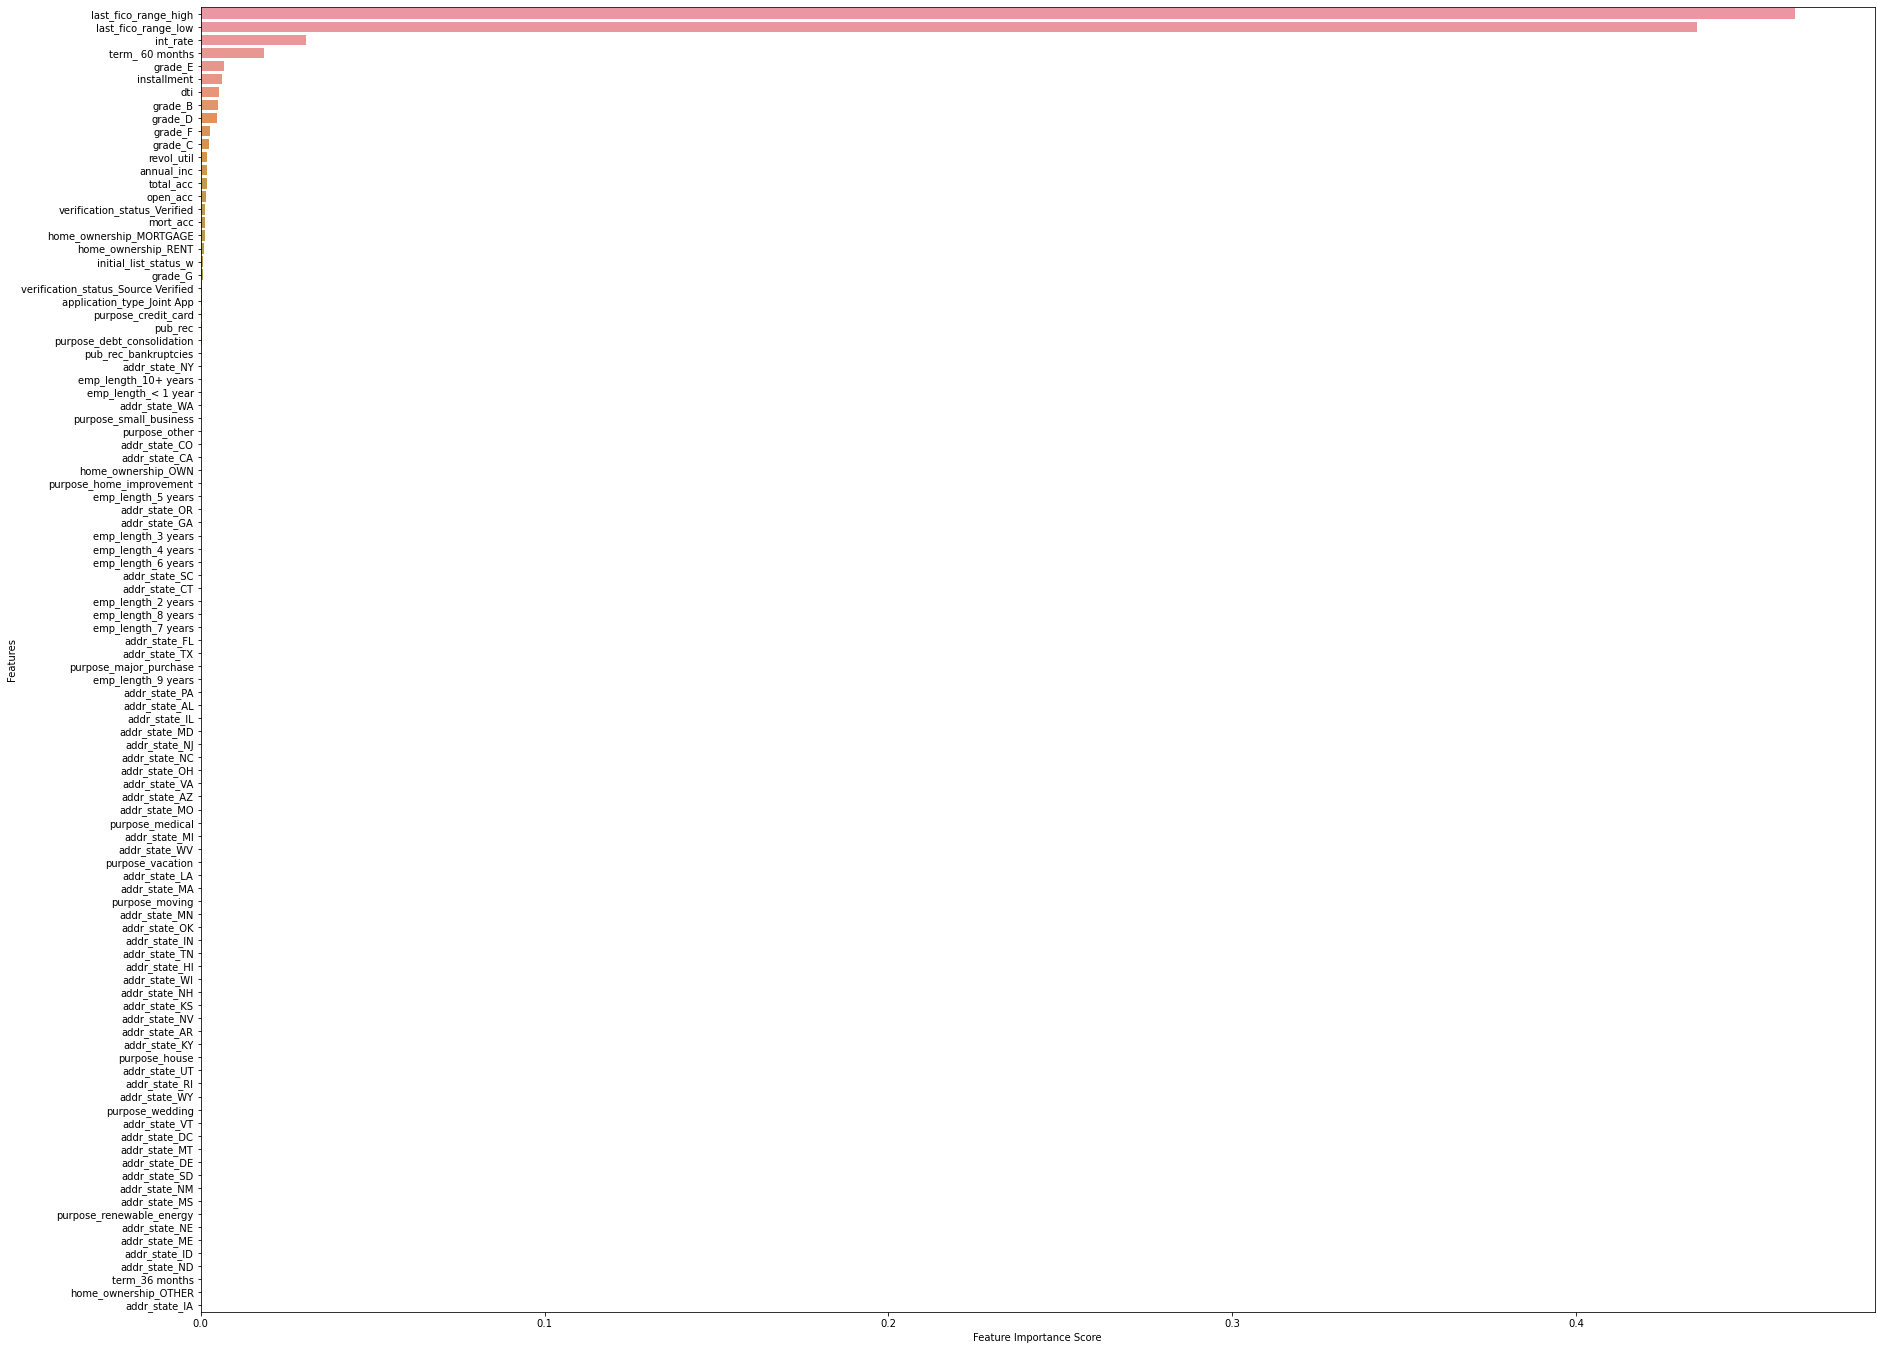

In [31]:
feature_importance_vis(feature_importance)

<a id="6"></a> <br>
### Confusion Matrix

In [32]:
cnf_matrix = metrics.confusion_matrix(y_test,y_test_pred)
cnf_matrix

array([[43053,  6640],
       [ 4006, 45581]])

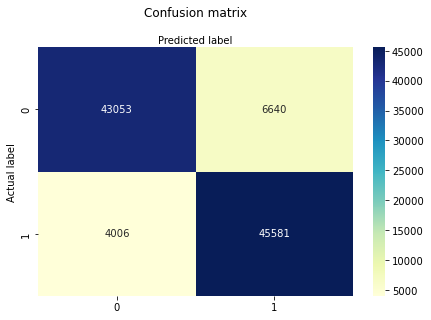

In [33]:
confusion_metrix_vis(cnf_matrix)

In [34]:
target_names = ['Fully Paid','Charge-off']
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

  Fully Paid       0.91      0.87      0.89     49693
  Charge-off       0.87      0.92      0.90     49587

    accuracy                           0.89     99280
   macro avg       0.89      0.89      0.89     99280
weighted avg       0.89      0.89      0.89     99280



<a id="7"></a> <br>
### ROC_Curve

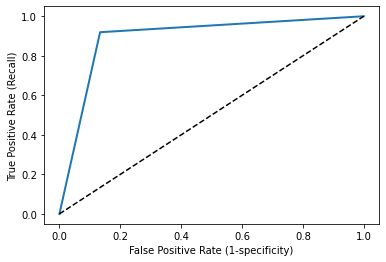

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr,tpr)

<a id="8"></a> <br>
### Plot of Precision and Recall Versus the Decision Threshold

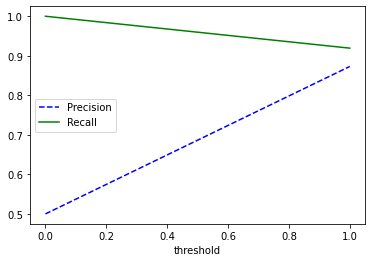

In [36]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

The performance of logistic regression and random forest is comparable when the sample size is large enough.  And, since we have so much data, deep learning may be able to improve performance even more 🤔. However, choosing the most current data to retrain may be the best option.